In this notebook, we'll try to solve to a problem that arose when I was working on the Kaggle What's Cooking challenge (see my previous posts on the subject [here](http://flothesof.github.io/kaggle-whats-cooking-machine-learning.html) and [here](http://flothesof.github.io/kaggle-whatscooking-bokeh-plots.html)). 

In this challenge, the data, which consists of recipes, contains a few quirks. For example, the data may contain names of brands  such as *knorr garlic minicub*, or mention weights and quantities that should have been cleaned up beforehand *(10 oz.) frozen chopped spinach, thawed and squeezed dry*.

The goal of this notebook is therefore to develop a method that suggests better ingredient names in an automatic way, based on a given recipe.

The outline of this blog post is as follows: we will first look at some overall statistics about the data, then develop a probabilistic model inspired by the principle behind spellcheckers and google auto-correct as explained by [Peter Norvig](http://norvig.com/spell-correct.html) and finally apply it to the machine learning algorithm used in the previous posts, the logistic regression.

# Statistics about the data, at ingredient and word level

In this section, we'll do some basic data exploration. In particular, let's try to answer the following questions:

- how many ingredients do we find in the data? how many are unique?
- how many individual words make up these ingredients?

First, let's load the data. We read it using codecs because pandas hasn't support for specifying encoding in the json loading routine (see <http://blog.nexusger.de/2015/11/python-pandas-and-json_read-with-utf-8-encoding/>).

In [1]:
import pandas as pd

In [13]:
import codecs
df_train = pd.read_json(codecs.open('train.json', 'r', 'utf-8'))

The head of the dataframe looks like this:

In [14]:
df_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


Now, let's build a single list with all the ingredients found in the dataset.

In [15]:
all_ingredients_text = []
for ingredient_list in df_train.ingredients:
    all_ingredients_text += [ing.lower() for ing in ingredient_list]

Let's have a look at the stats. We have the following number of ingredients in our recipes:

In [16]:
len(all_ingredients_text)

428275

Among those, the number of unique ingredients is:

In [17]:
len(set(all_ingredients_text))

6703

How about looking at these ingredients in terms of words? We can split each ingredient at a word boundary using a regexp and then count them:

In [18]:
import re
re.split(re.compile('[,. ]+'), 'KRAFT Shredded Pepper Jack Cheese with a TOUCH OF PHILADELPHIA')

['KRAFT',
 'Shredded',
 'Pepper',
 'Jack',
 'Cheese',
 'with',
 'a',
 'TOUCH',
 'OF',
 'PHILADELPHIA']

Let's do that and compute the number of words and then the unique words:

In [19]:
splitter = re.compile('[,. ]+')
all_words = []
for ingredient in all_ingredients_text:
    all_words += re.split(splitter, ingredient)

In [20]:
len(all_words)

807802

How about unique ones?

In [21]:
len(set(all_words))

3152

So to conclude, our dataset consists of:

- 428275 ingredients
- among which 6703 are unique
- all these ingredients are made of 807802 words
- among which 3152 are unique


Let's now turn to the problems one can see with these ingredients.

# Why some ingredients found in the data are strange

The longest ingredient names found in the dataset are:

In [22]:
sorted(set(all_ingredients_text), key=len, reverse=True)[:50]

['pillsbury™ crescent recipe creations® refrigerated seamless dough sheet',
 'kraft mexican style shredded four cheese with a touch of philadelphia',
 'bertolli vineyard premium collect marinara with burgundi wine sauc',
 'kraft shredded pepper jack cheese with a touch of philadelphia',
 'hidden valley® farmhouse originals italian with herbs dressing',
 'hidden valley® original ranch salad® dressing & seasoning mix',
 'condensed reduced fat reduced sodium cream of mushroom soup',
 'hellmannâ€™ or best food canola cholesterol free mayonnais',
 'condensed reduced fat reduced sodium cream of chicken soup',
 "i can't believ it' not butter! made with olive oil spread",
 'wish-bone light asian sesame ginger vinaigrette dressing',
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
 'kraft mexican style 2% milk finely shredded four cheese',
 'kraft shredded low-moisture part-skim mozzarella cheese',
 'hurst family harvest chipotle lime black bean soup mix',
 'reduced fat reduced sodi

What's going on here? Several observations can be made from this ingredient list:

- some ingredients contain special symbols that are not relevant (trademark, copyright, ...)
- some ingredients feature brand names, for instance *KRAFT, Pillsbury, Hidden Valley*, that I would say are not relevant to the identification of the ingredient itself and that I would thus want to exclude
- some ingredients contain sentences of english words instead of ingredients *i can't believ it' not butter! made with olive oil spread*
- some ingredients contain spelling errors *burgundi wine sauc* should actually be spelled *burgundy wine sauce*
- some ingredients contain quantities of ingredients that shouldn't be there: *2 1/2 to 3 lb. chicken, cut into serving pieces*

Ideally, we want a function that returns a more relevant version of these ingredients. For example:

| original ingredient | improved ingredient |
|---------------------|---------------------|
| pillsbury™ crescent recipe creations® refrigerated seamless dough sheet |  refrigerated seamless dough sheet |
| i can't believe it's not butter!® all purpose sticks | all purpose sticks |
| 2 1/2 to 3 lb. chicken, cut into serving pieces | chicken pieces |

These suggested improved ingredients are not unique and depend upon the knowledge of the person formulating them. The problem is that they're not easy to systematically generate. Therefore, it would be great if we could use a model based on the data itself to suggest them. This is what we're going to do in the next section.

# Building a simple model 

## Theory 

Given an ingredient, we have a choice to throw out some of its components (i.e. words). Judging if a component of an ingredient is useful or not is difficult. However, by following [Peter Norvig's approach on spell correcting](http://norvig.com/spell-correct.html) (or see these slides at Cornell University <https://courses.cit.cornell.edu/info4300_2011fa/slides/25.pdf> that explain Peter's approach in detail), we can formulate the problem of throwing out ingredient components in a probabilistic way. Although not stated in Norvig's writeup, this approach is close to something called a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). 

Let's take a closer look at what we want to do. We want our improved ingredient to maximize its probability given our input ingredient:

$$
\DeclareMathOperator*{\argmax}{arg\,max}
\argmax_{b}P\left({b \mid i}\right)
$$

Here, I denoted by $b$ the better ingredient and by $i$ the original ingredient.

The previous expression can be transformed according to Bayes Rule (following Peter Norvig) to yield:

$$
\argmax_{b} {P\left({i \mid b}\right) P(b) \over P(i)}
$$

Given that the ingredient $i$ is fixed, we neglect the denominator (as Peter does) and end up with:

$$
\argmax_{b} P\left({i \mid b}\right) P(b)
$$

This leaves us with three terms that balance out: 

- the probability of occurence of ingredient in our data $P(b)$ (this will favor commonly used ingredients)
- the error model, which says how likely it is that the input ingredient $i$ is a modified version of the better ingredient $b$
- the argmax, our control mechanism, which chooses the $b$ that gives the best combined probability score


Our error model will be that we can only delete words from our ingredient. So what we need is to generate a list of possible ingredients based on our original ingredient by substracting words. Also, we will assume that word order doesn't matter, so we can represent an ingredient by a set.

## Modelling ingredients using sets 

**Ingredients** contain a fixed number of words. We will therefore model them as **frozensets** of **words**. This will allow us to manipulate them more easily in the remaining document.

Let's define a function that creates an ingredient from a text string:

In [24]:
import re

def to_ingredient(text):
    "Transforms text into an ingredient."
    return frozenset(re.split(re.compile('[,. ]+'), text))

Let's build a list of all our ingredients using this function:

In [25]:
all_ingredients = [to_ingredient(text) for text in all_ingredients_text]

In [26]:
all_ingredients[:10]

[frozenset({'lettuce', 'romaine'}),
 frozenset({'black', 'olives'}),
 frozenset({'grape', 'tomatoes'}),
 frozenset({'garlic'}),
 frozenset({'pepper'}),
 frozenset({'onion', 'purple'}),
 frozenset({'seasoning'}),
 frozenset({'beans', 'garbanzo'}),
 frozenset({'cheese', 'crumbles', 'feta'}),
 frozenset({'flour', 'plain'})]

Let's now implement our algorithm given our model of an ingredient.

## Implementation 

We can now write a function that generates all possible candidate ingredients that can be built from a starting ingredient, using combinations found in the Python standard library.

In [27]:
import itertools

def candidates(ingredient):
    "Returns a list of candidate ingredients obtained from the original ingredient by keeping at least one of them."
    n = len(ingredient)
    possible = []
    for i in range(1, n + 1):
        possible += [frozenset(combi) for combi in itertools.combinations(ingredient, i)]
    return possible

Let's see how this works on examples:

In [28]:
candidates(to_ingredient("tomato and herb pasta sauce"))

[frozenset({'pasta'}),
 frozenset({'herb'}),
 frozenset({'sauce'}),
 frozenset({'and'}),
 frozenset({'tomato'}),
 frozenset({'herb', 'pasta'}),
 frozenset({'pasta', 'sauce'}),
 frozenset({'and', 'pasta'}),
 frozenset({'pasta', 'tomato'}),
 frozenset({'herb', 'sauce'}),
 frozenset({'and', 'herb'}),
 frozenset({'herb', 'tomato'}),
 frozenset({'and', 'sauce'}),
 frozenset({'sauce', 'tomato'}),
 frozenset({'and', 'tomato'}),
 frozenset({'herb', 'pasta', 'sauce'}),
 frozenset({'and', 'herb', 'pasta'}),
 frozenset({'herb', 'pasta', 'tomato'}),
 frozenset({'and', 'pasta', 'sauce'}),
 frozenset({'pasta', 'sauce', 'tomato'}),
 frozenset({'and', 'pasta', 'tomato'}),
 frozenset({'and', 'herb', 'sauce'}),
 frozenset({'herb', 'sauce', 'tomato'}),
 frozenset({'and', 'herb', 'tomato'}),
 frozenset({'and', 'sauce', 'tomato'}),
 frozenset({'and', 'herb', 'pasta', 'sauce'}),
 frozenset({'herb', 'pasta', 'sauce', 'tomato'}),
 frozenset({'and', 'herb', 'pasta', 'tomato'}),
 frozenset({'and', 'pasta', 'sau

In [29]:
candidates(to_ingredient('knorr chicken flavor bouillon cube'))

[frozenset({'flavor'}),
 frozenset({'chicken'}),
 frozenset({'cube'}),
 frozenset({'knorr'}),
 frozenset({'bouillon'}),
 frozenset({'chicken', 'flavor'}),
 frozenset({'cube', 'flavor'}),
 frozenset({'flavor', 'knorr'}),
 frozenset({'bouillon', 'flavor'}),
 frozenset({'chicken', 'cube'}),
 frozenset({'chicken', 'knorr'}),
 frozenset({'bouillon', 'chicken'}),
 frozenset({'cube', 'knorr'}),
 frozenset({'bouillon', 'cube'}),
 frozenset({'bouillon', 'knorr'}),
 frozenset({'chicken', 'cube', 'flavor'}),
 frozenset({'chicken', 'flavor', 'knorr'}),
 frozenset({'bouillon', 'chicken', 'flavor'}),
 frozenset({'cube', 'flavor', 'knorr'}),
 frozenset({'bouillon', 'cube', 'flavor'}),
 frozenset({'bouillon', 'flavor', 'knorr'}),
 frozenset({'chicken', 'cube', 'knorr'}),
 frozenset({'bouillon', 'chicken', 'cube'}),
 frozenset({'bouillon', 'chicken', 'knorr'}),
 frozenset({'bouillon', 'cube', 'knorr'}),
 frozenset({'chicken', 'cube', 'flavor', 'knorr'}),
 frozenset({'bouillon', 'chicken', 'cube', 'flav

The final step is to compute probabilities of candidate words. This is done using a counter of ingredients: the higher the count, the higher its probability (we don't bother normalizing here).

In [31]:
from collections import Counter

c = Counter(all_ingredients)

c.most_common(20)

[(frozenset({'salt'}), 18049),
 (frozenset({'oil', 'olive'}), 7972),
 (frozenset({'onions'}), 7972),
 (frozenset({'water'}), 7457),
 (frozenset({'garlic'}), 7380),
 (frozenset({'sugar'}), 6434),
 (frozenset({'cloves', 'garlic'}), 6237),
 (frozenset({'butter'}), 4848),
 (frozenset({'black', 'ground', 'pepper'}), 4785),
 (frozenset({'all-purpose', 'flour'}), 4632),
 (frozenset({'pepper'}), 4438),
 (frozenset({'oil', 'vegetable'}), 4385),
 (frozenset({'eggs'}), 3388),
 (frozenset({'sauce', 'soy'}), 3296),
 (frozenset({'kosher', 'salt'}), 3113),
 (frozenset({'green', 'onions'}), 3078),
 (frozenset({'tomatoes'}), 3058),
 (frozenset({'eggs', 'large'}), 2948),
 (frozenset({'carrots'}), 2814),
 (frozenset({'butter', 'unsalted'}), 2782)]

Now we're all set to compute the best candidate for a given input.

First, let's build the probability evaluation for a possible ingredient using a default dict (so that we don't end up asking for an ingredient that doesn't exist):

In [32]:
from collections import defaultdict
probability = defaultdict(lambda: 1, c.most_common())

Let's test the probability:

In [33]:
probability[to_ingredient('pasta and herb')]

1

In [34]:
probability[to_ingredient('tomato sauce')]

867

Seems like what we expect: tomato sauce has a higher probability than pasta and herb, which doesn't appear in our initial words.

Let's now write the function that yields the most probable replacement ingredient among all possible candidates.

In [35]:
def best_replacement(ingredient):
    "Computes best replacement ingredient for a given input."
    return max(candidates(ingredient), key=lambda c: probability[c])

Let's now look at some examples:

In [36]:
best_replacement(to_ingredient("tomato sauce"))

frozenset({'sauce', 'tomato'})

In [37]:
best_replacement(to_ingredient("pasta and herb"))

frozenset({'pasta'})

In [38]:
best_replacement(to_ingredient("kraft mexican style shredded four cheese with a touch of philadelphia"))

frozenset({'cheese'})

These examples all look good. What about the less frequent ingredients we had in our data?

In [53]:
pd.DataFrame([(text, 
               " ".join(best_replacement(to_ingredient(text)))) 
              for text in sorted(set(all_ingredients_text), key=len, reverse=True)[:50]],
            columns=['original ingredient', 'improved ingredient'])

,original ingredient,improved ingredient
0,pillsbury™ crescent recipe creations® refriger...,dough
1,kraft mexican style shredded four cheese with ...,cheese
2,bertolli vineyard premium collect marinara wit...,wine
3,kraft shredded pepper jack cheese with a touch...,pepper
4,hidden valley® farmhouse originals italian wit...,herbs
5,hidden valley® original ranch salad® dressing ...,seasoning
6,condensed reduced fat reduced sodium cream of ...,cream
7,hellmannâ€™ or best food canola cholesterol fr...,canola
8,condensed reduced fat reduced sodium cream of ...,chicken
9,i can't believ it' not butter! made with olive...,oil olive


This is interesting: a lot of the ingredients get well simplified, which is exactly what we want. Two comments:

- some simplifications are not the ones expected *i can't believe it's not butter!® all purpose sticks*, *reduced sodium reduced fat cream of mushroom soup*
- some get simplified **too much**: *skinless and boneless chicken breast fillet* becomes *chicken*, *reduced sodium italian style stewed tomatoes* becomes *tomatoes*

This model fails to take into account one thing: if we leave out too many ingredients in our replacement ingredient, the distance to the original ingredient increases. This observation is analogous to Peter Norvig's spell checker, where he considers the possible candidates by increasing edit distance: first words that have only one modification compared to the original word, then two modifications, then three... 

To compensate for this oversimplifcation, let's modify our procedure to keep a new ingredient that is as close as possible to the original.

# Building a slightly more elaborate model

The only thing we have to change is the way our candidates function works. Instead of generating all possibilites it should return only the ones that exist in our vocabulary of recipes with the least possible number of modifications. Here the modifications can be thought of leaving out a given number of words, by increasing the number of words left out.

In [40]:
def candidates_increasing_distance(ingredient, vocabulary):
    "Returns candidate ingredients obtained from the original ingredient by substraction, largest number of ingredients first."
    n = len(ingredient)
    for i in range(n - 1, 1, -1):
        possible = [frozenset(combi) for combi in itertools.combinations(ingredient, i) 
                    if frozenset(combi) in vocabulary]
        if len(possible) > 0:
            return possible
    return [ingredient]

We will define our vocabulary by the already existing counted ingredients:

In [41]:
vocabulary = dict(c.most_common())

In [42]:
list(vocabulary.keys())[:10]

[frozenset({'chicken', 'cubes', 'stock'}),
 frozenset({'creations®',
            'crescent',
            'dough',
            'pillsbury™',
            'recipe',
            'refrigerated',
            'seamless',
            'sheet'}),
 frozenset({'nori', 'shredded'}),
 frozenset({'eye', 'of', 'roast', 'round'}),
 frozenset({'gumbo', 'mixture', 'vegetable'}),
 frozenset({'curry', 'green', 'paste', 'thai'}),
 frozenset({'bouillon', 'chicken', 'cube', 'flavor', 'knorr'}),
 frozenset({'beef', 'roast', 'shoulder'}),
 frozenset({'grained'}),
 frozenset({'dried', 'ear', 'mushrooms', 'wood'})]

Let's test our function on a few examples:

In [43]:
candidates_increasing_distance(to_ingredient("bottled clam juice"), vocabulary)

[frozenset({'clam', 'juice'})]

In [45]:
candidates_increasing_distance(to_ingredient('hidden valley original ranch spicy ranch dressing'), vocabulary)

[frozenset({'dressing', 'ranch'})]

In [47]:
candidates_increasing_distance(to_ingredient("skinless and boneless chicken breast fillet"), vocabulary)

[frozenset({'boneless', 'breast', 'chicken', 'skinless'})]

In [48]:
candidates_increasing_distance(to_ingredient("reduced sodium italian style stewed tomatoes"), vocabulary)

[frozenset({'italian', 'stewed', 'style', 'tomatoes'})]

As we see, this works better on the examples that got simplified too much using the previous model.

Let's now write a new function for computing the best replacement, that takes into account the probabilities:

In [49]:
def best_replacement_increasing_distance(ingredient, vocabulary):
    "Computes best replacement ingredient for a given input."
    return max(candidates_increasing_distance(ingredient, vocabulary), key=lambda w: vocabulary[w])

And let's apply this to our lesser used ingredients:

In [54]:
pd.DataFrame([(text, 
               " ".join(best_replacement_increasing_distance(to_ingredient(text), vocabulary))) 
              for text in sorted(set(all_ingredients_text), key=len, reverse=True)[:50]],
            columns=['original ingredient', 'improved ingredient'])

,original ingredient,improved ingredient
0,pillsbury™ crescent recipe creations® refriger...,refrigerated seamless dough crescent
1,kraft mexican style shredded four cheese with ...,cheese shredded
2,bertolli vineyard premium collect marinara wit...,wine marinara bertolli vineyard with burgundi ...
3,kraft shredded pepper jack cheese with a touch...,kraft jack pepper cheese shredded
4,hidden valley® farmhouse originals italian wit...,herbs italian
5,hidden valley® original ranch salad® dressing ...,ranch dressing
6,condensed reduced fat reduced sodium cream of ...,mushroom fat cream reduced soup of sodium
7,hellmannâ€™ or best food canola cholesterol fr...,best canola cholesterol mayonnais food or free...
8,condensed reduced fat reduced sodium cream of ...,cream chicken reduced soup condensed of sodium
9,i can't believ it' not butter! made with olive...,oil olive


This result is interesting: the refined labels given here seem much better than the originals. However, there are still problems with the new ingredients. In particular, special symbols pollute the data. Therefore it's a good idea to first clean the data before employing our method.

Hopefully, this leads us to a better ingredient names, leading to better classification. To assert this, we'll train again on the dataset and see if we can expect some improvement compared to our previous model.

# Training a machine learning model

First, let's train the [previous model](http://flothesof.github.io/kaggle-whats-cooking-machine-learning.html):

In [55]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let's evaluate the accuracy of our model by doing a K-fold cross validation (training the model several times and check the error each time).

In [56]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
import numpy as np
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

In [57]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
evaluate_cross_validation(logistic, X, y, 5)

[ 0.79195475  0.78830924  0.78290383  0.79019485  0.78124214]
Mean score: 0.787 (+/-0.002)


Now that we have an initial evaluation of our algorithm, let's feed it our better vectors. All we have to do is rebuild the X matrix using our new feature ingredients. We also perform some string substitution to take into account the special characters.

In [63]:
def clean_string(ingredient_text):
    "Cleans the ingredient from special characters and returns it as lowercase."
    return "".join([char for char in ingredient_text.lower() if char.isalnum() or char.isspace()])

Let's test this:

In [64]:
clean_string("frank's® redhot® original cayenne pepper sauce")

'franks redhot original cayenne pepper sauce'

In [65]:
clean_string("2 1/2 to 3 lb. chicken, cut into serving pieces")

'2 12 to 3 lb chicken cut into serving pieces'

In [66]:
clean_string("i can't believe it's not butter!® all purpose sticks")

'i cant believe its not butter all purpose sticks'

In [93]:
clean_string("extra-virgin olive oil")

'extravirgin olive oil'

Finally, we can put together our function for improving a list of ingredients from the dataframe. We'll use a treshold for improving ingredients because very popular ingredients should just stay the same and not get cleaned. To do this, let's plot a graph for the value counts of the different ingredients found:

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

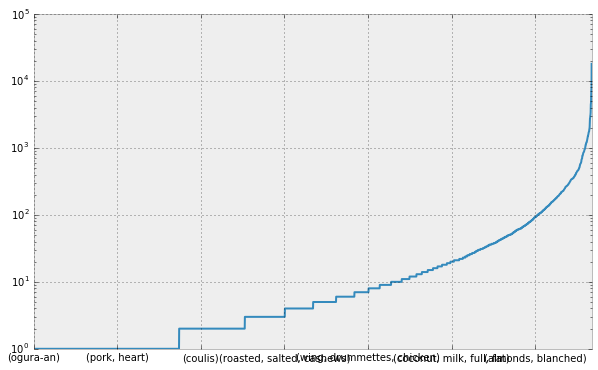

In [81]:
plt.figure(figsize=(10, 6))
pd.Series(vocabulary).sort_values().plot(logy=True)

This gives us a criterion: let's only improved ingredients whose counts are lower 100. The others are assumed to be already well defined.

In [94]:
def improve_ingredients(ingredient_list):
    "Improves the list of ingredients given as input."
    better_ingredients = []
    for ingredient in ingredient_list:
        cleaned_ingredient = clean_string(ingredient)
        if vocabulary[to_ingredient(cleaned_ingredient)] <= 100:
            better_ingredients.append(" ".join(best_replacement_increasing_distance(
                                        to_ingredient(cleaned_ingredient), vocabulary)))
        else:
            better_ingredients.append(cleaned_ingredient)
    return ";".join(better_ingredients)

Before using our function, we also need to rebuild our vocabulary using our new string cleaning function:

In [95]:
df_test = pd.read_json(codecs.open('test.json', 'r', 'utf-8'))
all_ingredients_text = []
for df in [df_train, df_test]:
    for ingredient_list in df.ingredients:
        all_ingredients_text += [clean_string(ing) for ing in ingredient_list]
all_ingredients = [to_ingredient(text) for text in all_ingredients_text]
c = Counter(all_ingredients)
vocabulary = dict(c.most_common())

In [96]:
df_train['better_ingredients'] = df_train['ingredients'].map(improve_ingredients)

In [97]:
df_train.head(10)

,cuisine,id,ingredients,all_ingredients,better_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce;black olives;grape tomatoes;ga...,romaine lettuce;black olives;grape tomatoes;ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour;ground pepper;salt;tomatoes;ground...,plain flour;ground pepper;salt;tomatoes;ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs;pepper;salt;mayonaise;cooking oil;green c...,eggs;pepper;salt;mayonaise;cooking oil;green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water;vegetable oil;wheat;salt,water;vegetable oil;wheat;salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper;shallots;cornflour;cayenne pepper...,black pepper;shallots;cornflour;cayenne pepper...
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge...",plain flour;sugar;butter;eggs;fresh ginger roo...,plain flour;sugar;butter;eggs;fresh ginger roo...
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli...",olive oil;salt;medium shrimp;pepper;garlic;cho...,olive oil;salt;medium shrimp;pepper;garlic;cho...
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo...",sugar;pistachio nuts;white almond bark;flour;v...,sugar;nuts pistachio;white bark almond;flour;v...
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por...",olive oil;purple onion;fresh pineapple;pork;po...,olive oil;purple onion;fresh pineapple;pork;po...
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-...",chopped tomatoes;fresh basil;garlic;extra-virg...,chopped tomatoes;fresh basil;garlic;extravirgi...


Let's now see the performance of this new version of the ingredients.

In [98]:
X = cv.fit_transform(df_train['better_ingredients'].values)

In [99]:
evaluate_cross_validation(logistic, X, y, 5)

[ 0.78830924  0.78680075  0.78214959  0.78918919  0.77923058]
Mean score: 0.785 (+/-0.002)


Well that's too bad... Our "clever" ingredients don't improve our score on the test set. Still let's try to submit a solution given that the test data might have some other issues (unknown ingredients that our method can simplify...).

In [100]:
df_test['better_ingredients'] = df_test['ingredients'].map(improve_ingredients)

And now, let's build our feature matrix:

In [101]:
X_submit = cv.transform(df_test['better_ingredients'].values)

In [102]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
y_submit = logistic.predict(X_submit)

In [104]:
with open("submission_better_words.csv", 'w') as f:
    f.write("id,cuisine\n")
    for i, cuisine in zip(df_test.id, enc.inverse_transform(y_submit)):
        f.write("{},{}\n".format(i, cuisine))

# Conclusion 

My submission (to the already closed contest) achieves a ranking of 576th, nothing to frill about. That's too bad. I would have hoped it would somehow improve my score, even though the K-fold had shown worse performance. Nevertheless, I think what is valuable here is that we have devised a way to improve a given text feature vector by using simple probability. This technique might be useful in other machine learning settings, when one can't trust the absolute reliability of the data. As demonstrated on the most exotic ingredients found in the dataset, this method can perform very well and transform an ingredient that is quite exotic into something that still makes sense.